In [1]:
import gymnasium as gym
import highway_env
import torch
import pickle
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [2]:
from PPOContinuous import PPOContinuous

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def eval_agent(agent, env, n_sim=10):
    """
    Monte Carlo evaluation of the agent.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done:
            action, _ = agent.get_action(state)  # deterministic sampling
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards

In [5]:
def train(env, agent, N_episodes, eval_every=50, reward_threshold=400, n_eval=10):
    total_time = 0
    losses = []
    reward_history = []

    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()

        while not done:
            action, log_prob = agent.get_action(state)
            env_action = np.array(action, dtype=np.float32).flatten()
            next_state, reward, terminated, truncated, _ = env.step(env_action)

            done = terminated or truncated
            agent.update(state, action, reward, done, next_state)

            state = next_state
            total_time += 1

        # After update, collect latest actor loss (if just updated this episode)
        if agent.scores:
            recent_loss = agent.scores[-1]
            losses.append(recent_loss.item())

        if (ep + 1) % eval_every == 0:
            rewards = eval_agent(agent, env, n_sim=n_eval)
            avg_reward = np.mean(rewards)
            reward_history.append(avg_reward)

            print(f"episode {ep + 1}: eval reward = {avg_reward:.2f}")
            if avg_reward >= reward_threshold:
                print("Reward threshold reached! Training complete.")
                break

    return losses, reward_history

In [11]:
with open("configs/highway_continuous_config.pkl", "rb") as f:
    config = pickle.load(f)

# Setup environment
env = gym.make("highway-fast-v0", render_mode=None, config=config)

# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [7]:
N_episodes=1000
eval_every=50

# Instantiate agent
agent = PPOContinuous(
    action_space=env.action_space,
    observation_space=env.observation_space,
    gamma=0.99,
    episode_batch_size=30,
    actor_learning_rate=1e-4,
    critic_learning_rate=1e-3,
    lambda_=0.95,
    eps_clip=0.1,
)

# Send models to GPU
agent.actor = agent.actor.to(device)
agent.critic = agent.critic.to(device)

In [8]:
# Run training
losses, rewards = train(env, agent, N_episodes=N_episodes, eval_every=eval_every, reward_threshold=300, n_eval=100)

episode 50: eval reward = 4.26
episode 100: eval reward = 4.79
episode 150: eval reward = 4.72
episode 200: eval reward = 4.58
episode 250: eval reward = 4.71
episode 300: eval reward = 4.21
episode 350: eval reward = 5.05
episode 400: eval reward = 5.12
episode 450: eval reward = 5.23
episode 500: eval reward = 4.67
episode 550: eval reward = 5.07
episode 600: eval reward = 4.24
episode 650: eval reward = 5.31
episode 700: eval reward = 5.16
episode 750: eval reward = 4.86
episode 800: eval reward = 5.01
episode 850: eval reward = 5.18
episode 900: eval reward = 4.64
episode 950: eval reward = 4.69
episode 1000: eval reward = 4.66


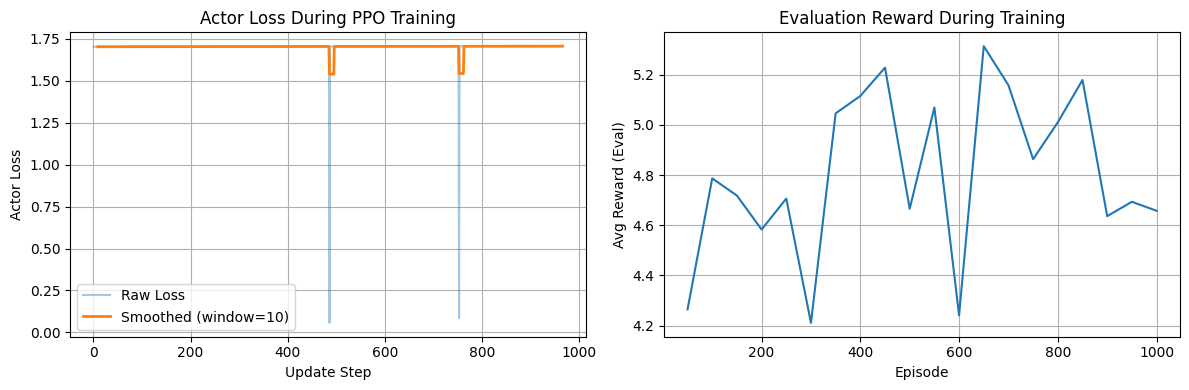

In [9]:
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(losses, label="Raw Loss", alpha=0.4)

# Smoothed loss curve
window = 10
if len(losses) >= window:
    smoothed_losses = np.convolve(losses, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, window-1 + len(smoothed_losses)), smoothed_losses,
             label=f"Smoothed (window={window})", linewidth=2)

plt.xlabel("Update Step")
plt.ylabel("Actor Loss")
plt.title("Actor Loss During PPO Training")
plt.legend()
plt.grid()

# Evaluation reward
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(rewards)+1) * eval_every, rewards, label="Eval Reward")
plt.xlabel("Episode")
plt.ylabel("Avg Reward (Eval)")
plt.title("Evaluation Reward During Training")
plt.grid()

plt.tight_layout()
plt.show()

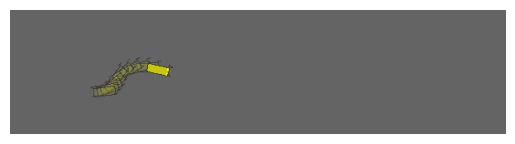

In [10]:
env = gym.make("highway-fast-v0", render_mode="rgb_array", config=config)
state, _ = env.reset()
done = False

for _ in range(100):
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).flatten().unsqueeze(0).to(device) 
        mean, std = agent.actor(state_tensor)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample().cpu().numpy().flatten()  # sampled continuous action

    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    clear_output(wait=True)
    plt.show()
    time.sleep(0.1)
    
env.close()